In [ ]:
# Mount Google Colab drive
from google.colab import drive
drive.mount('/content/drive')

# Imports
import os
import numpy as np
import pandas as pd
import glob
import seaborn as sns


# Change directory to location
loc = "/content/drive/MyDrive/KE_GNN/"
os.chdir(loc)
os.getcwd()


Mounted at /content/drive


'/content/drive/MyDrive/KE_GNN'

Functions for processing the results

In [ ]:
#processing the training and test results
def process_dataframes(loc, model_type):
    # Process test results
    test_dataframes = []
    for dfs in glob.glob(f'{loc}/{model_type}/*test_results*'):
        df = pd.read_csv(dfs)
        test_dataframes.append(df)
    results = pd.concat(test_dataframes, ignore_index=True)
    # Function to extract float value from tensor string
    def extract_float(value):
        if isinstance(value, str) and 'tensor' in value:
            start = value.find('(') + 1
            end = value.find(',')
            return float(value[start:end])
        return value

    # Process training results
    training_dataframes = []
    run_number = 1
    for dfs in glob.glob(f'{loc}/{model_type}/*training_results*'):
        df = pd.read_csv(dfs)
        df['run_number'] = run_number
        run_number += 1
        df['training loss'] = df['training loss'].apply(extract_float)
        training_dataframes.append(df)
    training = pd.concat(training_dataframes, ignore_index=True)

    return results, training

# WEIGHTS EXTRACTION

def weight_extraction(loc, model_type):
  dataframes = []
  run_number = 1
# Concatenate all DataFrames in the list into a single DataFrame
  for dfs in glob.glob('{}/{}/*weights*'.format(loc, model_type)):
    df = pd.read_csv(dfs).drop('Unnamed: 0', axis = 1)
    df['run_number'] = run_number
    df['epoch_value'] = df.index
    run_number = run_number + 1
    # Append the DataFrame to the list
    dataframes.append(df)
  weights = pd.concat(dataframes, ignore_index=True)
  weights.to_csv('KE_GAT_weights5.csv', index=False)
  return weights
# creating weights graph
def weights_graph(weight_df):
  draw_df = weight_df.reset_index().melt(id_vars=['epoch_value', 'run_number'], var_name='Clause')

  draw_df['run_number'] = draw_df.run_number.astype(str)
  draw_df = draw_df[draw_df['Clause'] != 'index']

  g = sns.FacetGrid(draw_df, col="Clause", hue="run_number",col_wrap = 2)
  g.map(sns.lineplot, "epoch_value", "value", alpha=.7)
  g.add_legend()
  return g



 # clause compliance
def clause_location_compliance(df):
  '''
  write description
  '''
  import pandas as pd
  import itertools

  clauses = df.columns[:-1].tolist()
  combinations = list(itertools.combinations(clauses, 2))


  clause_d = dict()
  for x in combinations:
      x1 = ''.join(x)
      clause_d[x1] = []
      for index, row in df.iterrows():
          if row[x[0]] == row[x[1]]:
              clause_d[x1].append('0')
          elif row[x[0]] < row[x[1]]:
              clause_d[x1].append('-')
          else:
              clause_d[x1].append('+')
  output = pd.DataFrame(clause_d)

  total_correct = 0
  total = 0
  for column in output.columns:
      for x in list(itertools.combinations(output[column].tolist(), 2)):
          total = total + 1
          if x[0] == x[1]:
              total_correct = total_correct + 1
  total_compliance = total_correct / total
  return total_compliance * 100

def clause_compliance(model_name, training_df, weight_df):
  idx = training_df.groupby('run_number')['optimised_f1'].idxmax()
  max_scores = training_df.loc[idx][['epoch','run_number']]
  max_scores['epoch'] = max_scores['epoch'] - 1
  clause_KE_GAT = weight_df.merge(max_scores, how = 'inner',
                     left_on=['run_number','epoch_value'], right_on = ['run_number','epoch']).drop(['epoch_value','epoch'], axis=1)
  print('{}, clause compliance: '.format(model_name) + str(clause_location_compliance(clause_KE_GAT)))
  return


# training results
def training_results(result_dict):
  result = []
  for key, value in result_dict.items():
    value2 = value.groupby('epoch').mean()
    value2['model name'] = key
    result.append(value2)
  training_df = pd.concat(result).drop(['Unnamed: 0', 'run_number'], axis = 1)
  draw_df = training_df.reset_index().melt(id_vars=['epoch', 'model name'], var_name='Clause')
  g = sns.FacetGrid(draw_df, col="Clause", hue="model name",col_wrap = 2, sharey = False)

  ordered_titlelist = ['Training Loss', 'Optimised F1', 'F1 Threshold','Recall', 'Precision']
  for idx,ax in enumerate(g.axes.flat):
      ax.set_title(ordered_titlelist[idx])

  g.map(sns.lineplot, "epoch", "value", alpha=.7)
  g.add_legend()
  return result
def validation_set_result(result_dict):
  result = []
  for key, value in result_dict.items():
    if key != 'XGBoost':
     value2 =  pd.DataFrame(value.groupby('run_number')['optimised_f1'].agg('max').agg(['mean','std'])).T
     value2['model name'] = key
     result.append(value2)
    else:
      value2 = pd.DataFrame(value['Valid f1'].agg(['mean','std'])).T
      value2.rename(columns={'Valid f1': 'optimised_f1'}, inplace=True)
      value2['model name'] = key
      result.append(value2)
    training_df = pd.concat(result)
  return training_df

# results on the test set
def Test_results(result_dict):
  result = []
  for key, value in result_dict.items():
    if key != 'XGBoost':
      value2 =  (value[['test_train_thresh_f1', 'test_f1']].agg(['mean','std'])).T
      value2['model name'] = key
      result.append(value2)
    else:
      value2 = pd.DataFrame(xg_boost[['test f1 v_thres', 'test f1 t_thres']].agg(['mean','std'])).T

      value2['model name'] = key
      result.append(value2)
    results = pd.concat(result)
    results['statistic'] = results.index
    VF1_results = results[results['statistic'].isin(['test f1 v_thres', 'test_train_thresh_f1'])].drop('statistic', axis = 1).reset_index(drop = True)
    TF1_results = results[~results['statistic'].isin(['test f1 v_thres', 'test_train_thresh_f1'])].drop('statistic', axis = 1).reset_index(drop = True)
  return VF1_results, TF1_results

Main Experiment

In [ ]:
loc = "/content/drive/MyDrive/KE_GNN/Main Experiment/output/"
# Main Experiment XGboost model
xg_boost = pd.read_csv('{}XGBOOST/XG_boost_results.csv'.format(loc))
# Main Experiment GCN model
GCN_results, GCN_training = process_dataframes(loc, 'GCN')
# Main Experiment GAT model
GAT_results, GAT_training = process_dataframes(loc, 'GAT')
# Main Experiment KE_GAT 10 clauses model
KE_GAT10_results, KE_GAT10_training = process_dataframes(loc, 'KeGAT_10_clause')
KE_GAT10_weights = weight_extraction(loc, 'KeGAT_10_clause')
# Main Experiment KE_GAT 5 clauses model
KE_GAT5_results, KE_GAT5_training = process_dataframes(loc, 'KeGAT_5_clause')
KE_GAT5_weights = weight_extraction(loc, 'KeGAT_5_clause')
# Main Experiment KE_GCN 10 clauses model
KE_GCN10_results, KE_GCN10_training = process_dataframes(loc, 'KeGCN_10_clause')
KE_GCN10_weights = weight_extraction(loc, 'KeGCN_10_clause')
# Main Experiment KE_GCN 5 clausesmodel
KE_GCN5_results, KE_GCN5_training = process_dataframes(loc, 'KeGCN_5_clause')
KE_GCN5_weights = weight_extraction(loc, 'KeGCN_5_clause')

validation set results 
                  mean           std model name
optimised_f1  0.810082  3.137620e-02        GAT
optimised_f1  0.802517  1.775516e-02  KE_GAT_10
optimised_f1  0.828999  1.715351e-02   KE_GAT_5
optimised_f1  0.802517  1.775516e-02  KE_GCN_10
optimised_f1  0.863260  2.358949e-03   KE_GCN_5
optimised_f1  0.862967  1.276579e-03        GCN
Valid f1      0.823806  1.241267e-16    XGBoost


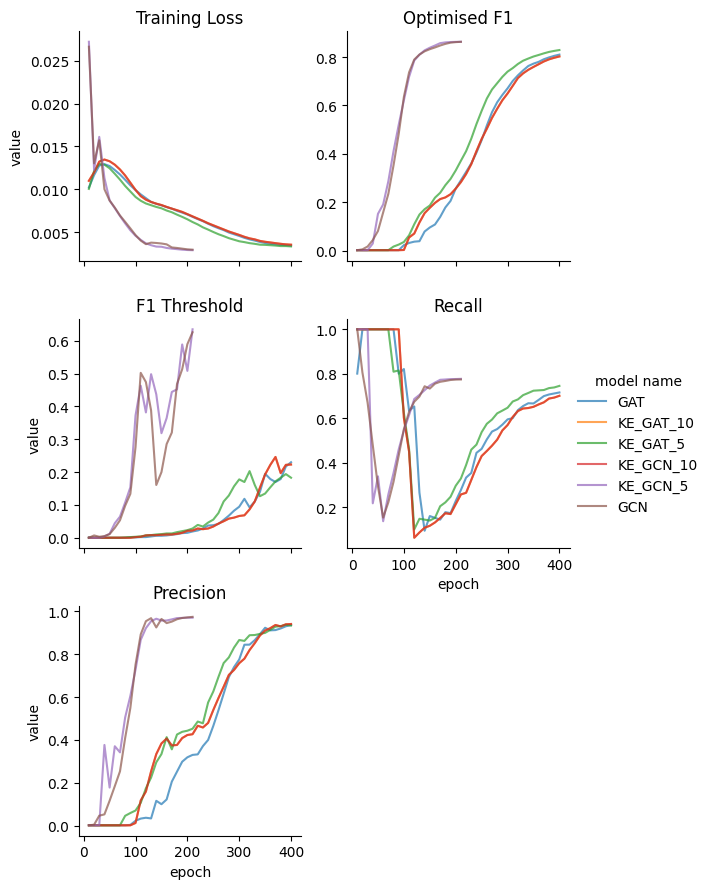

In [ ]:
# training results


training_dict = {
    'GAT':GAT_training,
    'KE_GAT_10': KE_GAT10_training,
    'KE_GAT_5': KE_GAT5_training,
    'KE_GCN_10':KE_GCN10_training,
    'KE_GCN_5': KE_GCN5_training,
    'GCN':GCN_training
}
training_results(training_dict)
training_dict['XGBoost'] = xg_boost
#validation set results
print('validation set results ')
print(validation_set_result(training_dict))




In [ ]:
# Test set results
result_dict = {
    'GAT':GAT_results,
    'KE_GAT_10': KE_GAT10_results,
    'KE_GAT_5': KE_GAT5_results,
    'KE_GCN_10':KE_GCN10_results,
    'KE_GCN_5': KE_GCN5_results,
    'GCN':GCN_results,
    'XGBoost': xg_boost}

VF1_results, TF1_results = Test_results(result_dict)
print('Validation optimised test set results:')
print(VF1_results)
print('test optimised test set results:')
print(TF1_results)

Validation optimised test set results:
       mean       std model name
0  0.765306  0.049390        GAT
1  0.780912  0.016920  KE_GAT_10
2  0.785517  0.044630   KE_GAT_5
3  0.780912  0.016920  KE_GCN_10
4  0.815120  0.002896   KE_GCN_5
5  0.814127  0.001999        GCN
6  0.672558  0.000000    XGBoost
test optimised test set results:
       mean       std model name
0  0.784943  0.038110        GAT
1  0.792724  0.019376  KE_GAT_10
2  0.791076  0.038885   KE_GAT_5
3  0.792724  0.019376  KE_GCN_10
4  0.818368  0.003821   KE_GCN_5
5  0.817798  0.002413        GCN
6  0.689642  0.000000    XGBoost


KeGAT with 10 Clauses, clause compliance: 99.11111111111111


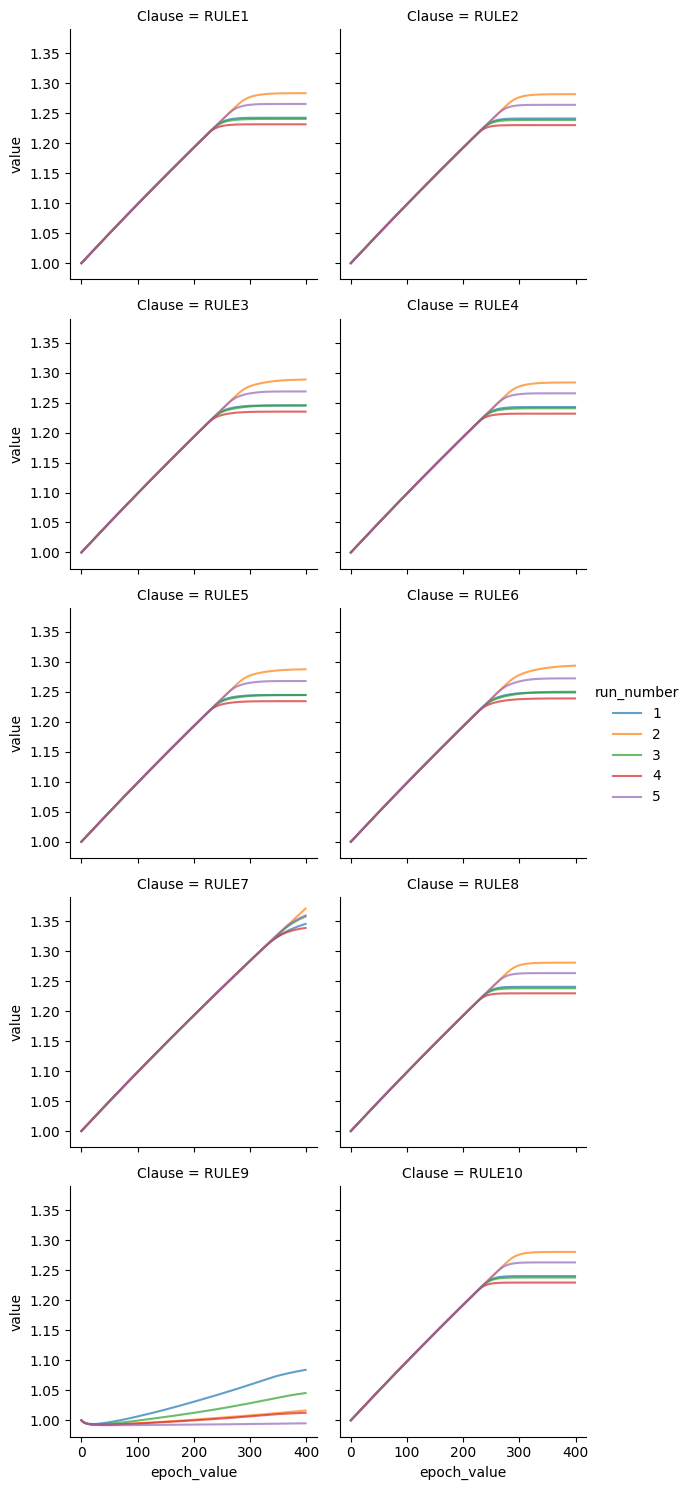

In [ ]:
# KeGAT with 10 clauses weight results
weights_graph(KE_GAT10_weights)
# clause compliance
clause_compliance('KeGAT with 10 Clauses', KE_GAT10_training, KE_GAT10_weights)

KeGAT with 5 Clauses, clause compliance: 94.0


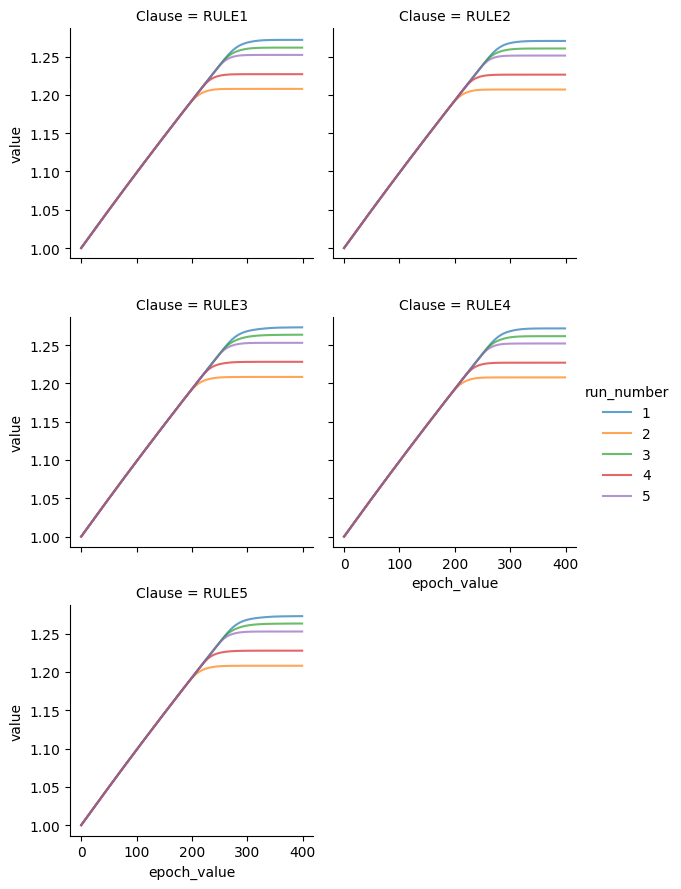

In [ ]:
# KeGAT with 5 clauses weight results
weights_graph(KE_GAT5_weights)
# clause compliance
clause_compliance('KeGAT with 5 Clauses', KE_GAT5_training, KE_GAT5_weights)

KeGCN with 10 Clauses, clause compliance: 99.11111111111111


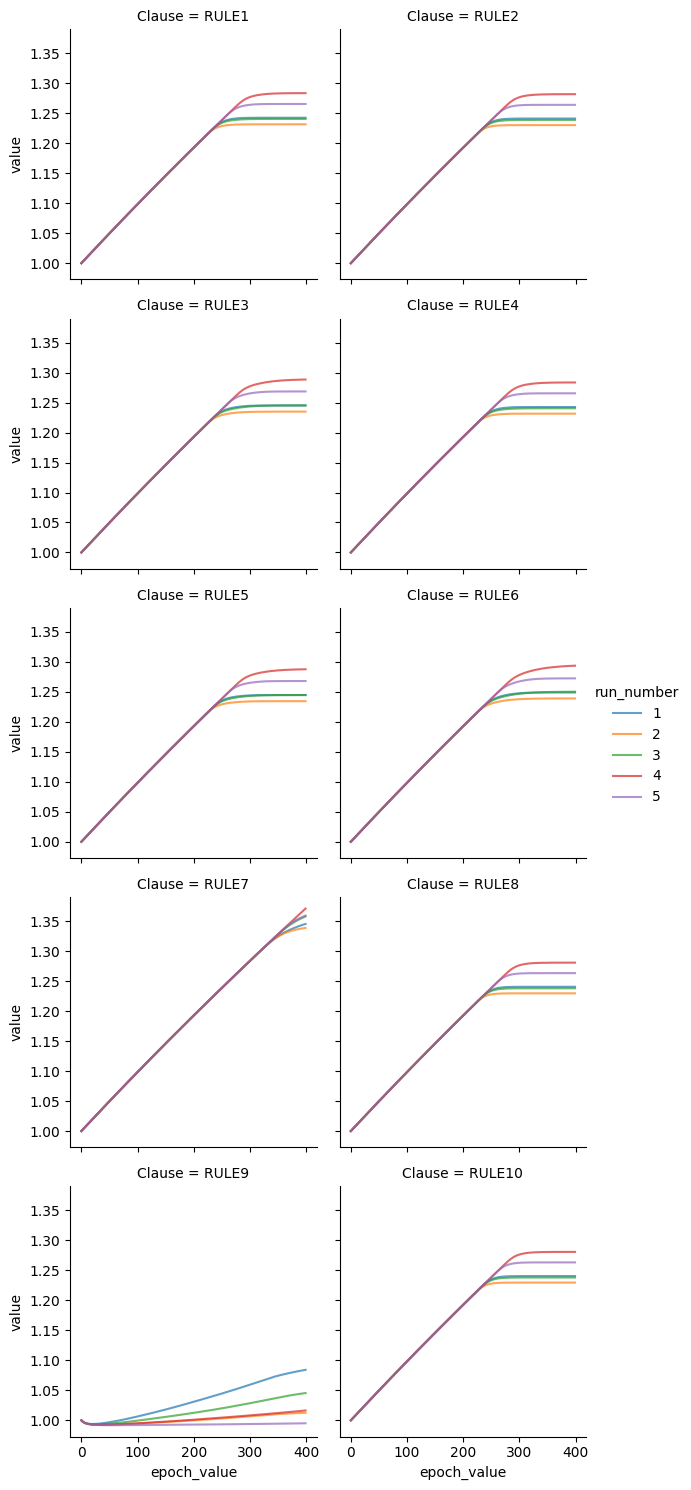

In [ ]:
# KeGCN with 10 clauses weight results
weights_graph(KE_GCN10_weights)
# clause compliance
clause_compliance('KeGCN with 10 Clauses', KE_GCN10_training, KE_GCN10_weights)

KeGCN with 5 Clauses, clause compliance: 100.0


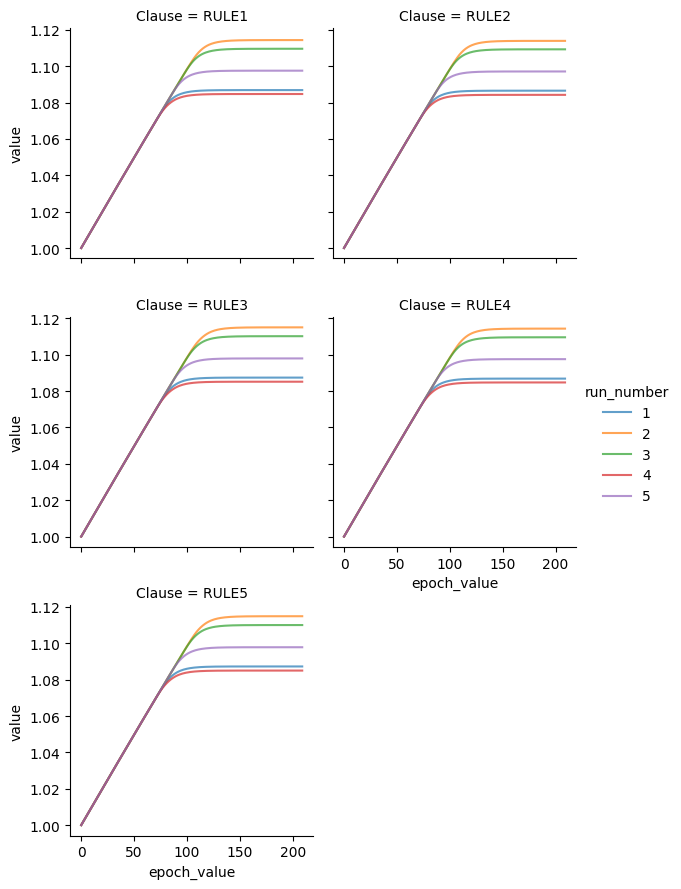

In [ ]:
# KeGCN with 5 clauses weight results
weights_graph(KE_GCN5_weights)
# clause compliance
clause_compliance('KeGCN with 5 Clauses', KE_GCN5_training, KE_GCN5_weights)

Post hoc results:

In [31]:
loc = "/content/drive/MyDrive/KE_GNN/Post Hoc/output/"
# Post Hoc  XGboost model
xg_boost = pd.read_csv('{}XGBOOST/XG_boost_results_post.csv'.format(loc))
# Post Hoc  GCN model
GCN_results, GCN_training = process_dataframes(loc, 'GCN')
# Post Hoc  GAT model
GAT_results, GAT_training = process_dataframes(loc, 'GAT')
# Post Hoc  KE_GAT 10 clauses model
KE_GAT10_results, KE_GAT10_training = process_dataframes(loc, 'KeGAT_10_clause')
KE_GAT10_weights = weight_extraction(loc, 'KeGAT_10_clause')
# Post Hoc KE_GCN 10 clauses model
KE_GCN10_results, KE_GCN10_training = process_dataframes(loc, 'KeGCN_10_clause')
KE_GCN10_weights = weight_extraction(loc, 'KeGCN_10_clause')


validation set results 
                  mean       std model name
optimised_f1  0.737041  0.070163        GAT
optimised_f1  0.789721  0.012908  KE_GAT_10
optimised_f1  0.827615  0.008430  KE_GCN_10
optimised_f1  0.658153  0.364431        GCN
Valid f1      0.471677  0.000000    XGBoost


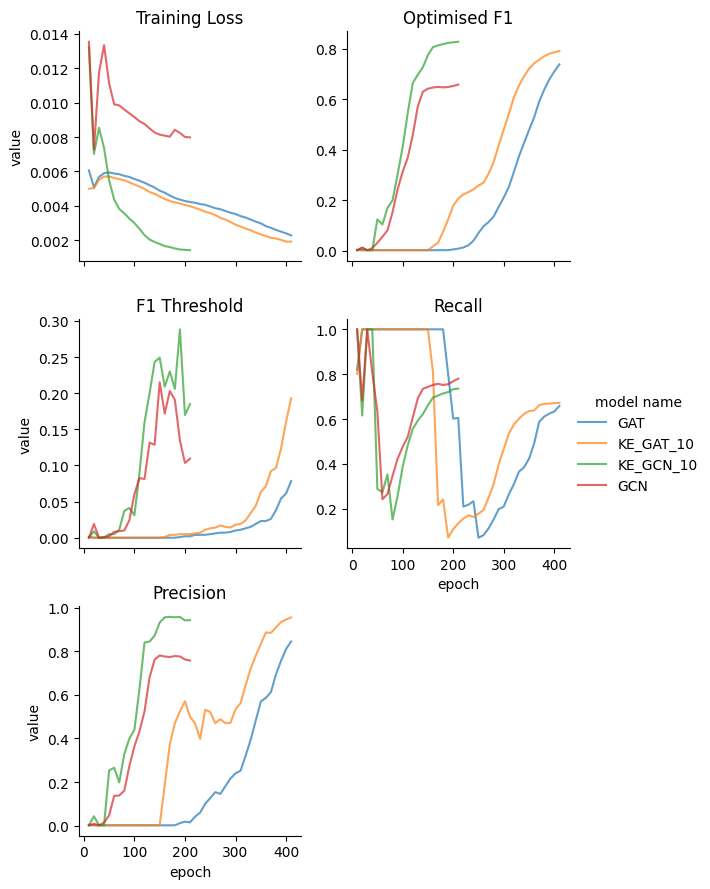

In [36]:
# training results


training_dict = {
    'GAT':GAT_training,
    'KE_GAT_10': KE_GAT10_training,
    'KE_GCN_10':KE_GCN10_training,
    'GCN':GCN_training
}
training_results(training_dict)
training_dict['XGBoost'] = xg_boost
#validation set results
print('validation set results ')
print(validation_set_result(training_dict))




In [33]:
# Test set results
result_dict = {
    'GAT':GAT_results,
    'KE_GAT_10': KE_GAT10_results,
    'KE_GCN_10':KE_GCN10_results,
    'GCN':GCN_results,
    'XGBoost': xg_boost}

VF1_results, TF1_results = Test_results(result_dict)
print('Validation optimised test set results:')
print(VF1_results)
print('test optimised test set results:')
print(TF1_results)

Validation optimised test set results:
       mean       std model name
0  0.734461  0.085770        GAT
1  0.798984  0.017794  KE_GAT_10
2  0.739545  0.116121  KE_GCN_10
3  0.627634  0.348965        GCN
4  0.475890  0.000000    XGBoost
test optimised test set results:
       mean           std model name
0  0.738874  8.909135e-02        GAT
1  0.807211  1.777503e-02  KE_GAT_10
2  0.824935  2.930002e-03  KE_GCN_10
3  0.662240  3.668789e-01        GCN
4  0.488557  6.206335e-17    XGBoost


KeGAT with 10 Clauses, clause compliance: 98.66666666666667


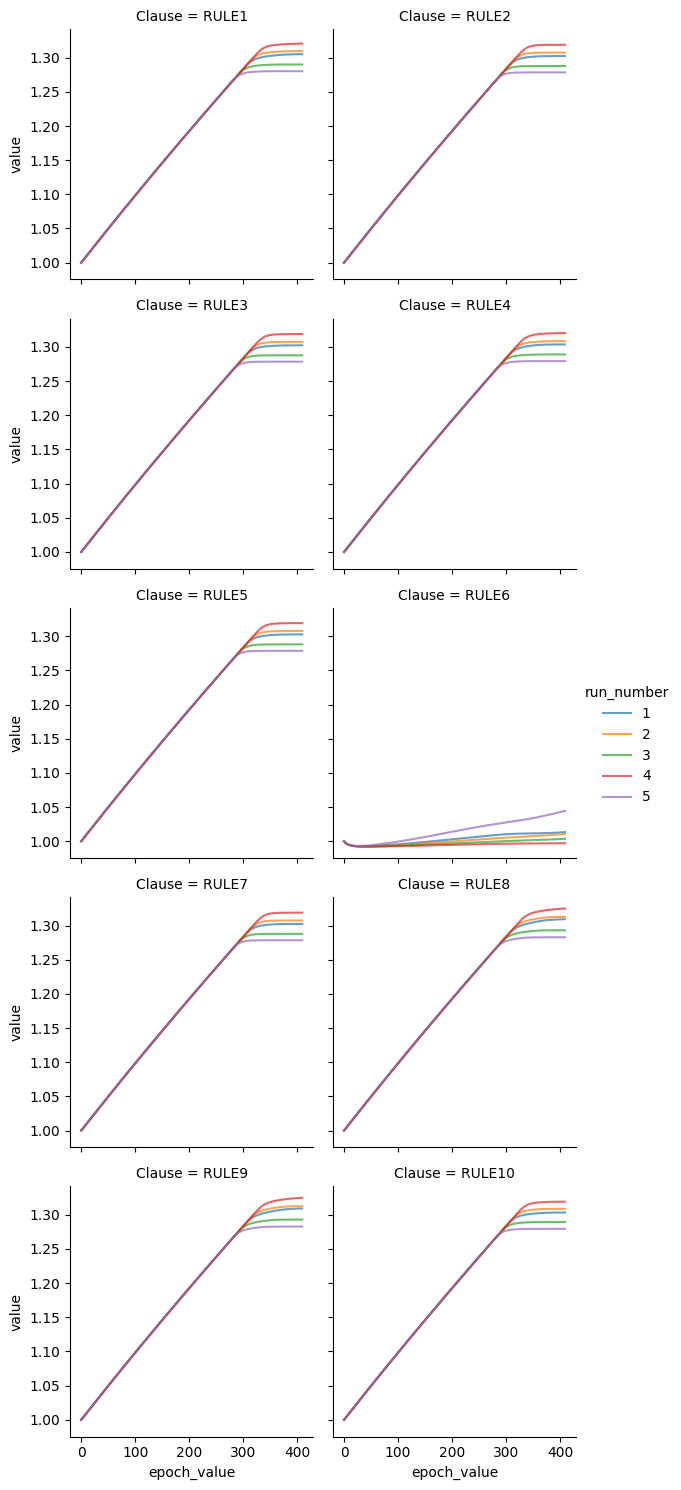

In [34]:
# KeGAT with 10 clauses weight results
weights_graph(KE_GAT10_weights)
# clause compliance
clause_compliance('KeGAT with 10 Clauses', KE_GAT10_training, KE_GAT10_weights)

KeGCN with 10 Clauses, clause compliance: 99.11111111111111


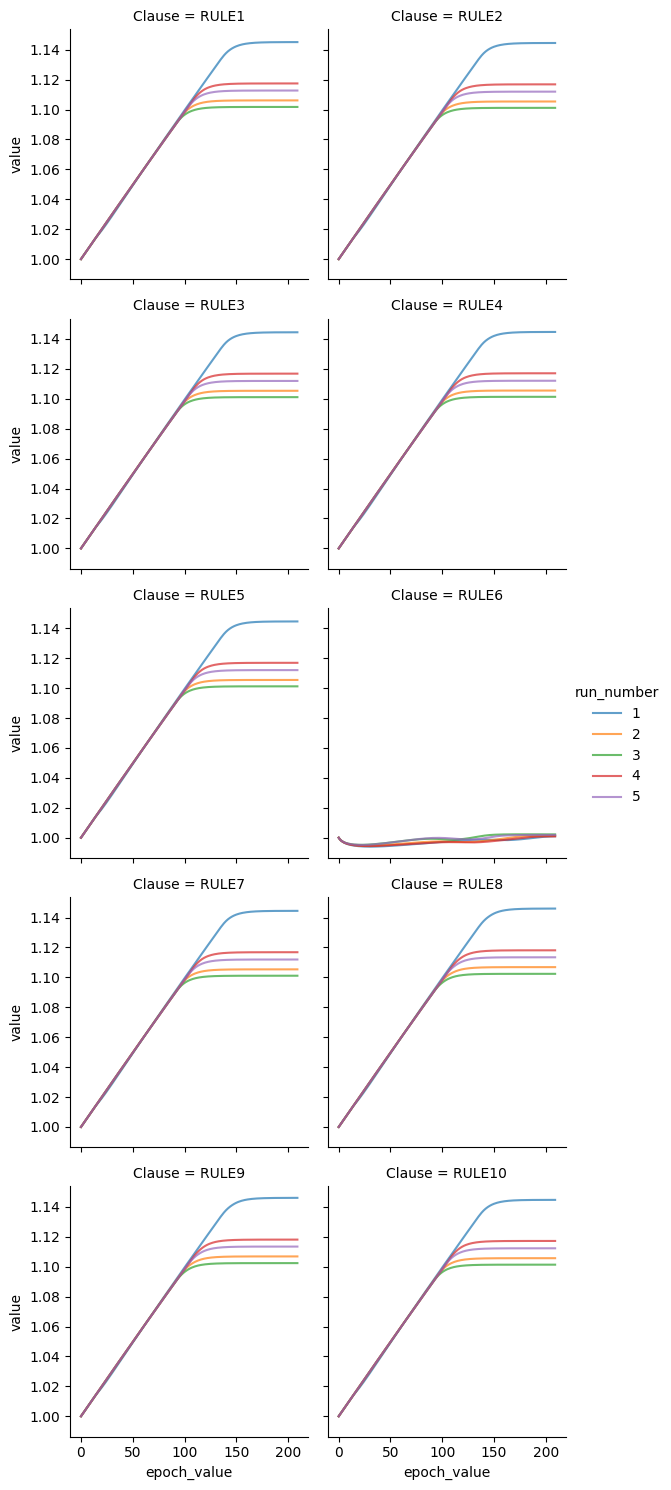

In [35]:
# KeGCN with 10 clauses weight results
weights_graph(KE_GCN10_weights)
# clause compliance
clause_compliance('KeGCN with 10 Clauses', KE_GCN10_training, KE_GCN10_weights)